In [1]:
%load_ext autoreload
%autoreload 2

import json
import numpy as np
import pandas as pd

from final_project import loader, builder, models, plots
from final_project.models import ModelENUM
from pathlib import Path
from sklearn.model_selection import train_test_split

In [2]:
df = loader.get_df(all_files=True)
df = df[df["Origin"] == "BOS"]
df = df[
    [
        "DistanceGroup",
        "DayofMonth",
        "Month",
        "Year",
        "Duplicate",
        "ArrDel15",
        "DistanceGroup",
        "WeatherDelay",
        "NASDelay",
        "SecurityDelay",
        "Operating_Airline",
        "Dest",
    ]
]
df = builder.encodeFrame(df)

delay_df = df[df["ArrDel15"] > 0.5].sample(n=20000)
on_time_df = df[df["ArrDel15"] <= 0.5].sample(n=80000)
sample_df = pd.concat([delay_df, on_time_df], ignore_index=True)


x = sample_df.drop(columns=["ArrDel15"])
y = sample_df[["ArrDel15"]]
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=150
)
print(df.shape)

(512522, 122)


In [4]:
svm_pipeline = models.get_pipeline(ModelENUM.SVM)
param_grid = [
    # models.get_svm_param(gamma=['auto', 'scale'], c_list=[1, 10], coef0=[0, 1, 2], degree=[2,3], kernel=['linear', 'poly'], max_iter=[5000], cache_size=[8000])
    models.get_svm_param(
        gamma=["auto"],
        c_list=[1, 10],
        coef0=[0, 1],
        kernel=["linear", "poly", "rbf"],
        max_iter=[1500],
    )
    # models.get_svm_param(gamma=[2, 3, 4, 'scale', 'auto'], c_list=[1e-2, 1e-1, 1e1, 1e2], coef0=[0, 1, 2], kernel=['linear', 'poly', 'rbf'])
    # models.get_svm_param(gamma=[2], c_list=[1e-2], coef0=[1], kernel=['linear'])
]
grid_search = models.get_grid_search_cv(
    pipeline=svm_pipeline, param_grid=param_grid, cv=3, n_jobs=15
)

In [5]:
svm_model = grid_search.fit(x_train, y_train.to_numpy().ravel())

Fitting 3 folds for each of 24 candidates, totalling 72 fits
[CV 1/3; 1/24] START svm__C=1, svm__cache_size=4000, svm__coef0=0, svm__degree=3, svm__gamma=auto, svm__kernel=linear, svm__max_iter=10000, svm__probability=True


In [5]:
params = models.get_best_params(models.ModelENUM.SVM, svm_model)
results = models.analyze_model(svm_model, x_test, x_train, y_test, y_train)
print(json.dumps(params, indent=2))
print(json.dumps(results, indent=2))
models.save_model(models.ModelENUM.SVM, svm_model)

{
  "gamma": "auto",
  "kernel": "linear",
  "C": 10
}
{
  "Test Accuracy": 0.6666666666666666,
  "Train Accuracy": 0.6513605442176871,
  "Precision": 1.0,
  "Recall": 0.5,
  "F-Beta Score": 0.6666666666666666,
  "F1 Score": 0.6666666666666666
}


414


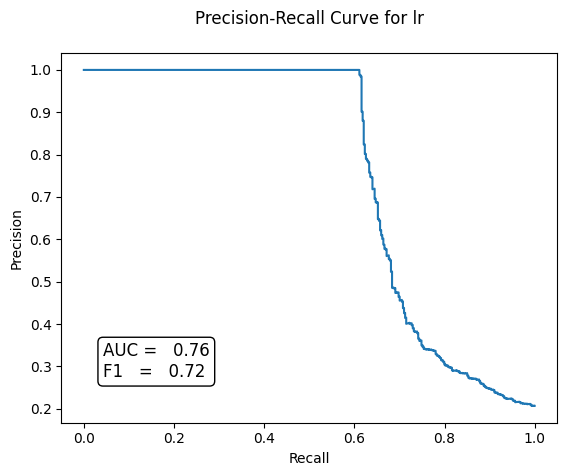

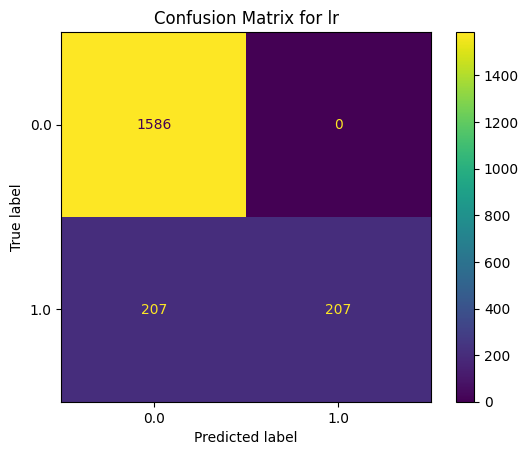

In [6]:
number_true = np.count_nonzero(y_test == 1)
print(number_true)

y_prob = svm_model.predict_proba(x_test)[:, 1]
y_pred = svm_model.predict(x_test)
plots.save_precision_recall_curve("lr", "test_file", y_test, y_prob)
plots.save_confusion_matrix("lr", "test_file", y_test, y_pred)